# Extrema Fitting

The problem of extrema fitting is the following: given a set
of data, with pairs of inputs and outputs, determine a model
which passes above or below every point in the set.

In [1]:
import numpy as np

import sys

def psa(D, n, I):
    # y
    y_rows = []
    
    for i in D[1]:
        y_rows.append([i])
    
    y = np.matrix(y_rows)
    
    # P Matrix
    P_rows = []
    
    for x in D[0]:
        row = []
        
        for i in range(n, -1, -1):
            row.append(x**i)
        
        P_rows.append(row)
    
    P = np.matrix(P_rows)
    
    # Support
    S_f = []
    
    y_hat_elems = []
    
    for i in I:
        S_f.append(D[0][i])
        
        y_hat_elems.append([D[1][i]])
    
    y_hat = np.matrix(y_hat_elems)
    
    # P' Matrix
    Pr_rows = []
    
    for x in S_f:
        row = []
        
        for i in range(n, -1, -1):
            row.append(x**i)
        
        Pr_rows.append(row)
    
    Pr = np.matrix(Pr_rows)
    
    # First column of Pr
    Pr_f = -Pr[:,0]
    
    # Rest of Pr
    Pr_r = Pr[:,np.arange(1, n + 1)]
    
    S_pre = np.c_[Pr_f, y_hat]
    
    # Augumented Matrix
    Aug = np.c_[Pr_r, S_pre]
    
    I_Aug = Ext_Gauss_Jordan(Aug)
    
    S = np.r_[[[1, 0]], I_Aug[:][:,[3, 4]]]
    
    # Range Determination
    Q = P * S
        
    Qa = Q[:][:, 0]
    Qb = Q[:][:, 1]
    
    c = y - Qb
    
    print(Qa)
    print(c)
    
    a_min = -sys.float_info.max
    a_max = sys.float_info.max
    
    for i in range(0, len(D[0])):
        a = Qa[i][0, 0]
        b = c[i][0, 0]
        
        

#################################################

def Ext_Gauss_Jordan(Aug):
    n = Aug.shape[0]
    
    m = Aug.shape[1]
    
    for i in range(0, n):
        for j in range(i + 1, n):
            k = -(Aug[j][0, i]/Aug[i][0, i])
            
            Aug[j] = Aug[j] + k * Aug[i]
    
    for i in range(n - 1, -1, -1):
        for j in range(i - 1, -1, -1):
            k = -(Aug[j][0, m - (i + 1)]/Aug[i][0, m - (i + 1)])
            
            Aug[j] = Aug[j] + k * Aug[i]

    for i in range(0, n):
        Aug[i] = Aug[i]/Aug[i][0, i]
                
    return Aug

#################################################

D = [
        [0, 2, 6, 9, 12, 16],
        [0, 4, 2, 9, 3, 4]
]

psa(D, 3, [1, 3, 5])

[[-307]
 [ 113]
 [1145]
 [2276]
 [3893]
 [7085]]
[[ -1]
 [  1]
 [ -5]
 [ -1]
 [-10]
 [-13]]


## Example

Here, we apply the inclusive max-fit algorithms mentioned on the following data set:

$$D = \{(0, 0), (2, 4), (6, 2), (9, 9), (12, 3), (16, 4)\}$$

In the Python code below, we use the two functions for the two algorithms: `poly_f` represents the result of the supported polynomial method, while `exp_f` represents the result of the spike method.

Note that the `exp_f` method can be used for an arbitrary data set.

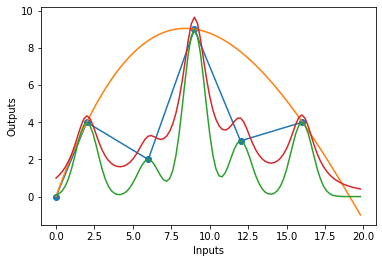

In [8]:
import matplotlib.pyplot as plt

import numpy as np

a = 1/392;

# Supported polynomial method
def poly_f(x):
    return a*(x**3) + (-27 * a - 5/49)*(x**2) \
        + (195*a + 90/49)*x + (-288 * a + 36/49)

def poly_f_opt(x):
    return (-288 * a + 36/49) + x*((195*a + 90/49) \
        + x*((-27 * a - 5/49) + x*a))

# Spike generator(s)
def spike_e(x, h, k):
    d = x - h;
    
    return k * np.exp(-1 * d * d);

def spike_x(x, h, k):
    d = x - h;
    
    return k / (1 + d * d);

# Spike model generator
def exp_f(x, D):
    sum = 0
    
    for i in range(0, 6):
        sum += spike_e(x, D[0][i], D[1][i])
    
    return sum

def x_f(x, D):
    sum = 0
    
    for i in range(0, 6):
        sum += spike_x(x, D[0][i], D[1][i])
    
    return sum

# Data
D = [
        [0, 2, 6, 9, 12, 16],
        [0, 4, 2, 9, 3, 4]
]

# Plotting the functions
plt.plot(D[0], D[1], marker = 'o')

x = np.arange(0, 20, 0.2)
plt.plot(x, [poly_f(x) for x in x])
plt.plot(x, [exp_f(x, D) for x in x])
plt.plot(x, [x_f(x, D) for x in x])

plt.ylabel('Outputs')
plt.xlabel('Inputs')

plt.show()

Now we present some practical statistics about these algorithms, such as their computation time and overall fit.

In [4]:
import time

x = np.arange(0, 100, 0.01)
              
print("Number of elements in x: " + str(x.size))

mu = np.average(D[1])

# Errors

poly_f_chi = 0
poly_f_opt_chi = 0
exp_f_chi = 0
x_f_chi = 0

for i in range(0, 6):
    poly_f_chi += (D[1][i] - poly_f(D[0][i]))**2
    poly_f_opt_chi += (D[1][i] - poly_f(D[0][i]))**2
    exp_f_chi += (D[1][i] - exp_f(D[0][i], D))**2
    x_f_chi += (D[1][i] - x_f(D[0][i], D))**2

# PSa Method

start = time.perf_counter()

for i in x:
    poly_f(x)
    
end = time.perf_counter()

print("\nPSa (Unoptimized):\n\ttime:\t" + str(end - start) + "\n\tlse:\t" + str(poly_f_chi))

# Optimized

start = time.perf_counter()

for i in x:
    poly_f_opt(x)
    
end = time.perf_counter()

print("\nPsa (Optimized):\n\ttime:\t" + str(end - start) + "\n\tlse:\t" + str(poly_f_opt_chi))

# Spike Method (exp_f)

start = time.perf_counter()

for i in x:
    exp_f(x, D)
    
end = time.perf_counter()

print("\nSpike (exp_f):\n\ttime:\t" + str(end - start) + "\n\tlse:\t" + str(exp_f_chi))

# Spike Method (x_f)

start = time.perf_counter()

for i in x:
    x_f(x, D)
    
end = time.perf_counter()

print("\nSpike (x_f):\n\ttime:\t" + str(end - start) + "\n\tlse:\t" + str(x_f_chi))

Number of elements in x: 10000

PSa (Unoptimized):
	time:	4.38860094499978
	lse:	64.10022516659721

Psa (Optimized):
	time:	0.19377336700017622
	lse:	64.10022516659721

Spike (exp_f):
	time:	7.195998118000716
	lse:	0.005370252053086325

Spike (x_f):
	time:	1.2007332579996728
	lse:	4.801672158308226


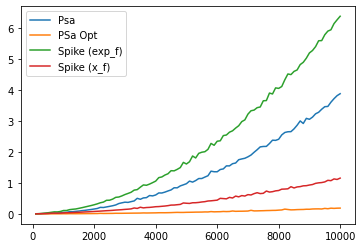

In [7]:
import numpy as np

import time

sizes = []

psa_times = []
psa_opt_times = []

exp_times = []
x_times = []

for k in range(1, 101):
    x = np.arange(0, 10 * k, 0.1)
    
    # PSa
    
    start = time.perf_counter()

    for i in x:
        poly_f(x)
    
    end = time.perf_counter()
    
    psa_times.append(end - start)
    
    # PSa Opt
    
    start = time.perf_counter()

    for i in x:
        poly_f_opt(x)
    
    end = time.perf_counter()
    
    psa_opt_times.append(end - start)
    
    # Spike (exp_f)
    
    start = time.perf_counter()

    for i in x:
        exp_f(x, D)
    
    end = time.perf_counter()
    
    exp_times.append(end - start)
    
    # Spike (x_f)
    
    start = time.perf_counter()

    for i in x:
        x_f(x, D)
    
    end = time.perf_counter()
    
    x_times.append(end - start)
    
    sizes.append(x.size)

plt.plot(sizes, psa_times, label="Psa")
plt.plot(sizes, psa_opt_times, label="PSa Opt")
plt.plot(sizes, exp_times, label="Spike (exp_f)")
plt.plot(sizes, x_times, label="Spike (x_f)")
plt.legend(loc="upper left")
plt.show()

From the results of the program, we can clearly see that the PSa method produces more efficient models, in terms of computation time.

However, as we shall soon see, this difference in computation time is flipped when considering the time it takes to construct the models. In fact, the spike method requires no time to create the model (see the first code chunk). This fly-by construction of a model that is much more accurate makes it a good alternative for application in which many models much be quickly computed.

What is interesting is that the optimized version of the spike method produces overwhelming results over the unoptimized version. For one, it takes less time to compute, as should be expected. However, it also has a much higher accuracy that the unoptimized version.

To investigate further, we collect data relating the number of terms of the Taylor series expansion of $e^{-x^2}$ in the optimized version of the spike method. --<
